# Protein Modification

* Find this notebook at `EpyNN/nnlive/ptm_protein/prepare_dataset.ipynb`. 
* Regular python code at `EpyNN/nnlive/ptm_protein/prepare_dataset.py`.

This notebook is part of the series on preparing data for Neural Network regression with EpyNN. 

It deals with a real world problem and therefore will focus on the problem itself, rather than basics that were reviewed along with the preparation of the following dummy dataset: 

* [Boolean dataset](../dummy_boolean/prepare_dataset.ipynb)
* [String dataset](../dummy_string/prepare_dataset.ipynb)
* [Time-series (numerical)](../dummy_time/prepare_dataset.ipynb)
* [Image (numerical)](../dummy_image/prepare_dataset.ipynb)

## Post Translational Modification (PTM) of Proteins

Post-Translational Modification (PTM) of proteins is an ensemble of mechanisms by which the primary sequence of a protein can be chemically modified after - and in some circumstances during - biosynthesis by the ribosomes.

When talking about *one* PTM, it generally refers to a given chemical group that may be covalently linked with given amino acid residues in proteins.

For instance, the formation of a phosphoester between a phosphate group and side-chain hydroxyl of serine, threonine and tyrosine is known as phosphorylation. While proteins overall may contain a given number of such residues, phosphorylation may occur particularly on a given subset, generally with respect to specific cellular conditions.

From a given number of chemically unmodified proteins (proteome), below is a list of some characteristics with respect to PTM:

* PTM increase chemical diversity: for a given *proteome*, there is a corresponding *phosphoproteome* or *oglcnacome* if talking about *O*-GlcNAcylation. Said explicitely, a chemically uniform protein may give rise to an ensemble of chemically distinct proteins upon modification.
* PTM may enrich gene's function: as for other mechanisms, the fact that a given gene product - the chemically unmodified protein - may be modified to yield distinct chemical entities is equivalent to multiplying the number of end-products from a single gene. As such, the number of functions for this gene is expected to increase, because distinct functions are achieved by distinct molecules, and this is actually what PTM do: create chemically distinct proteins from the same gene product.
* Chemical groups defining one PTM are numerous: among the most studied, one may cite phosphorylation, ubiquitinylation, *O*-GlcNActylation, methylation, succinylation, among dozens of others.

PTMs are major regulators of cell signaling and play a role in virtually every biological process.

As such, this is a big challenge to predict whether or not one protein may be modified with respect to one PTM.

Let's draw something to illustrate one aspect of the deal.

![2hr9](tctp.png)

This is a protein called [TCTP](https://www.rcsb.org/structure/2hr9) and above is shown a type of 3D model commonly used to represent proteins. The red sticks represent serine residues along the protein primary sequence. Those with label SER-46 and SER-64 where shown to undergo phosphorylation in cells.

But in theory, phosphorylation could occur on all serines within this structure. The reality is that such modifications only occur on *some* serines.

This is what we are going to challenge here, with a PTM called *O*-GlcNAcylation.

## Prepare a set of peptides

Let’s prepare a set of O-GlcNAcylated and presumably not *O*-GlcNAcylated peptide sequences.

### Imports

In [1]:
# EpyNN/nnlive/ptm_protein/prepare_dataset.ipynb
# Standard library imports
import tarfile
import random
import os

# Related third party imports
import wget
import numpy as np
import matplotlib.pyplot as plt

# Local application/library specific imports
from epynn.commons.library import read_file
from epynn.commons.logs import process_logs

Note the `tarfile` which is a Python built-in *standard* library and the first choice to deal with `.tar` archives and related.

### Seeding

In [2]:
random.seed(1)

For reproducibility.

### Download sequences

Simple function to download data from the cloud as `.tar` archive. Once uncompressed, it yields a `data/` directory containing `.dat` text files for positive and negative sequences.

In [3]:
def download_sequences():
    """Download a set of peptide sequences.
    """
    data_path = os.path.join('.', 'data')

    if not os.path.exists(data_path):

        # Download @url with wget
        url = 'https://synthase.s3.us-west-2.amazonaws.com/ptm_prediction_data.tar'
        fname = wget.download(url)

        # Extract archive
        tar = tarfile.open(fname).extractall('.')
        process_logs('Make: ' + fname, level=1)

        # Clean-up
        os.remove(fname)

    return None

Retrieve the data as follows.

In [4]:
download_sequences()

Check the directory.

In [5]:
for path in os.walk('data'):
    print(path)

('data', [], ['21_positive.dat', '21_negative.dat'])


Let’s have a quick look to what one file's content.

In [6]:
with open(os.path.join('data', '21_positive.dat'), 'r') as f:
    print(f.read().splitlines()[:5])

['SQDVSNAFSPSISKAQPGAPP', 'GPRIPDHQRTSVPENHAQSRI', 'QFSCKCLTGFTGQKCETDVNE', 'KLIKRLYVDKSLNLSTEFISS', 'QQKEGEQNQQTQQQQILIQPQ']


These are 21 amino-acids long peptide sequences.

Note that positive sequences are *Homo sapiens* *O*-GlcNAcylated peptides sourced from [The *O*-GlcNAc Database](https://www.oglcnac.mcw.edu).

Negative sequences are *Homo sapiens* peptide sequence not reported in the above-mentioned source. 

### Prepare dataset

Below is a function we use to prepare the labeled dataset.

In [7]:
def prepare_dataset(N_SAMPLES=100):
    """Prepare a set of labeled peptides.

    :param N_SAMPLES: Number of peptide samples to retrieve, defaults to 100.
    :type N_SAMPLES: int

    :return: Set of peptides.
    :rtype: tuple[list[str]]

    :return: Set of single-digit peptides label.
    :rtype: tuple[int]
    """
    # Single-digit positive and negative labels
    p_label = 0
    n_label = 1

    # Positive data are Homo sapiens O-GlcNAcylated peptide sequences from oglcnac.mcw.edu
    path_positive = os.path.join('data', '21_positive.dat')

    # Negative data are peptide sequences presumably not O-GlcNAcylated
    path_negative = os.path.join('data', '21_negative.dat')

    # Read text files, each containing one sequence per line
    positive = [[list(x), p_label] for x in read_file(path_positive).splitlines()]
    negative = [[list(x), n_label] for x in read_file(path_negative).splitlines()]

    # Shuffle data to prevent from any sorting previously applied
    random.shuffle(positive)
    random.shuffle(negative)

    # Truncate to prepare a balanced dataset
    negative = negative[:len(positive)]

    # Prepare a balanced dataset
    dataset = positive + negative

    # Shuffle dataset
    random.shuffle(dataset)

    # Truncate dataset to N_SAMPLES
    dataset = dataset[:N_SAMPLES]

    # Separate X-Y pairs
    X_features, Y_label = zip(*dataset)

    return X_features, Y_label

Let's check the function.

In [8]:
X_features, Y_label = prepare_dataset(N_SAMPLES=10)

for peptide, label in zip(X_features, Y_label):
    print(label, peptide)

0 ['T', 'A', 'A', 'M', 'R', 'N', 'T', 'K', 'R', 'G', 'S', 'W', 'Y', 'I', 'E', 'A', 'L', 'A', 'Q', 'V', 'F']
1 ['N', 'K', 'K', 'L', 'A', 'P', 'S', 'S', 'T', 'P', 'S', 'N', 'I', 'A', 'P', 'S', 'D', 'V', 'V', 'S', 'N']
1 ['R', 'G', 'A', 'G', 'S', 'S', 'A', 'F', 'S', 'Q', 'S', 'S', 'G', 'T', 'L', 'A', 'S', 'N', 'P', 'A', 'T']
0 ['T', 'D', 'N', 'D', 'W', 'P', 'I', 'Y', 'V', 'E', 'S', 'G', 'E', 'E', 'N', 'D', 'P', 'A', 'G', 'D', 'D']
0 ['G', 'Q', 'E', 'R', 'F', 'R', 'S', 'I', 'T', 'Q', 'S', 'Y', 'Y', 'R', 'S', 'A', 'N', 'A', 'L', 'I', 'L']
0 ['S', 'I', 'N', 'T', 'G', 'C', 'L', 'N', 'A', 'C', 'T', 'Y', 'C', 'K', 'T', 'K', 'H', 'A', 'R', 'G', 'N']
1 ['N', 'K', 'A', 'S', 'L', 'P', 'P', 'K', 'P', 'G', 'T', 'M', 'A', 'A', 'G', 'G', 'G', 'G', 'P', 'A', 'P']
1 ['A', 'S', 'V', 'Q', 'D', 'Q', 'T', 'T', 'V', 'R', 'T', 'V', 'A', 'S', 'A', 'T', 'T', 'A', 'I', 'E', 'I']
1 ['A', 'S', 'L', 'E', 'G', 'K', 'K', 'I', 'K', 'D', 'S', 'T', 'A', 'A', 'S', 'R', 'A', 'T', 'T', 'L', 'S']
1 ['R', 'R', 'Q', 'P', 'V', 

These sequences are centered with respect to the modified or presumably unmodified residue, which may be a serine or a threonine.

In [9]:
for peptide, label in zip(X_features, Y_label):
    print(label, peptide[len(peptide) // 2:len(peptide) // 2 + 1])

0 ['S']
1 ['S']
1 ['S']
0 ['S']
0 ['S']
0 ['T']
1 ['T']
1 ['T']
1 ['S']
1 ['S']


Because *O*-GlcNAcylation may impact Serine or Threonine, note that negative sequences with label ``0`` were prepared to also contain such residues at the same position.

We have already seen in [String dataset](../dummy_string/prepare_dataset.ipynb) how to perform [*one-hot encoding*](../dummy_string/prepare_dataset.ipynb#One-hot-encoding-of-string-features) of string features.

Just for fun, and also because you may like to use such data in convolutional networks, let's convert a peptide sequence into an image.

20
{'T': 0, 'S': 1, 'E': 2, 'L': 3, 'M': 4, 'A': 5, 'W': 6, 'C': 7, 'I': 8, 'P': 9, 'D': 10, 'V': 11, 'Q': 12, 'H': 13, 'R': 14, 'Y': 15, 'G': 16, 'K': 17, 'N': 18, 'F': 19}
['G', 'R', 'I', 'S', 'A', 'L', 'Q', 'G', 'K', 'L', 'S', 'K', 'L', 'D', 'Y', 'R', 'D', 'I', 'T', 'K', 'Q']
[16, 14, 8, 1, 5, 3, 12, 16, 17, 3, 1, 17, 3, 10, 15, 14, 10, 8, 0, 17, 12]


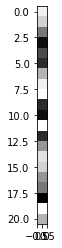

In [10]:
X_features, _ = prepare_dataset(N_SAMPLES=10)

# Flatten the list of lists (list of peptides) and make a set()
aas = list(set([feature for features in X_features for feature in features]))

# set() contains unique elements
print(len(aas))  # 20 amino-acids

e2i = {k: i for i, k in enumerate(aas)}  # element_to_idx encoder 0-19

features = X_features[0]

print(e2i)       # Encoder
print(features)  # Peptide before encoding
print([e2i[feature] for feature in features])  # After encoding

# NumPy array to plot as image
img_features = np.array([e2i[feature] for feature in features])
img_features = np.expand_dims(img_features, axis=1)

plt.imshow(img_features, cmap='gray')
plt.show()

Well, let’s reshape. The number 21 is divisible by 7 and 3.

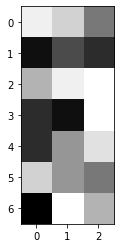

In [11]:
plt.imshow(img_features.reshape(7, 3), cmap='gray')
plt.show()

It seems to be working! We are done.

## Live examples

The function ``prepare_dataset()`` presented herein is used in the following live examples:

* Notebook at`EpyNN/nnlive/dummy_string/train.ipynb` or following [this link](train.ipynb). 
* Regular python code at `EpyNN/nnlive/dummy_string/train.py`.